# Assignment 8: Tracking and forecasting in conditions of measurement gaps


## Team №6:
1. Angelina Prokopeva
2. Nikita Gorbadey
3. Mark Griguletskii
4. Stanislav Savushkin

03.10.2019, Skoltech

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [9]:
generate_report = False
def plot(trace_num, x_data, y_data, xlable = 'xlable', ylable = 'ylable',
                legend = 'legend', title = 'title', mode='lines'):
    plot.counter += 1
    fig_name = 'images/' + str(plot.counter) + '.jpg'
    fig = go.Figure()
    for i in range(trace_num):
        fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode=mode, name=legend[i], showlegend = True))
    fig.update_layout(
        title=go.layout.Title(
            text=title,
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text=xlable
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=ylable
            )
        )
    )
    if generate_report is True:
        fig.write_image(fig_name)
        display(Image(fig_name))
    else:
        fig.show()
plot.counter = 0

### Working progress

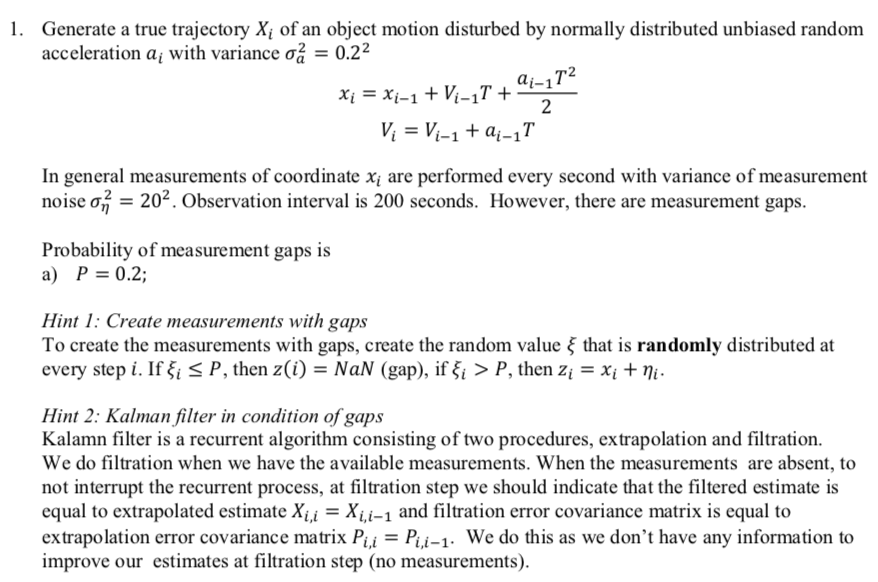

In [18]:
def motion_tragectory(size, T, sigma_a, X_init=0, V_init=0):
    "Function for generating motion trajectory with normally distributed random acceleration"
    out = np.zeros(size)
    V = np.zeros(size)
    out[0] = X_init
    V[0] = V_init
    a = np.random.normal(loc=0, scale=sigma_a, size=size)
    for i in range(1, size):
        V[i] = V[i-1] + a[i-1]*T
        out[i] = out[i-1] + V[i-1]*T + (a[i-1]*T**2)/2
    return out

In [19]:
def measured_trajectory_with_gaps(data, sigma, prob_of_gap=0.2):
    "Supplementary function for generating measured trajectory"
    p = np.random.uniform(size=data.size)
    n = np.random.normal(loc=0, scale=sigma, size=data.size)
    ret = np.empty(data.size)
    for i in range(data.size):
        if p[i] < prob_of_gap:
            ret[i] = np.NAN
        else:
            ret[i] = data[i] + n[i]
    return ret

In [20]:
N = 200
X_init = 5
V_init = 1
T = 1
sigma_a = 0.2
sigma_n = 20

# Generating true trajectory
x = motion_tragectory(N, T, sigma_a, X_init=X_init, V_init=V_init)

# Generating measurements
z = measured_trajectory_with_gaps(x, sigma_n)
num_points = np.linspace(1, N, num=N)

In [21]:
plot(2, [num_points, num_points], [x, z], title='True trajectory and its measurements', xlable='steps', ylable='coordinate',
     legend=['real trajectory', 'measured trajectory'])

On the plot we can see true trajectory and measurements with gap probability P = 0.2.

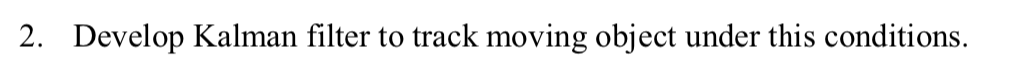

In [22]:
def kalman_filter(z, T, X_0=[0, 0], P_0=[[100, 0], [0, 100]], sigma_a=1, sigma_n=1, shift=7):
    shape = (z.size, 2)
    X_pred = np.zeros(shape)
    X_filt = np.zeros(shape)
    x_i_pred = np.zeros(shape[0])
    F = np.array([[1, T], [0, 1]])
    G = np.array([T**2/2, T]).T
    H = np.array([1, 0])
    X_0 = [2, 0]
    P_0_0 = [[10000, 0], [0, 10000]]
    
    # prepare parameters
    Q = G.dot(G.T.dot(sigma_a**2))
    R = sigma_n**2
    P_pred = np.zeros((shape[0], 2, 2))
    P_filt = np.zeros((shape[0], 2, 2))
    K = np.zeros(shape)

    X_filt[0] = X_0
    P_filt[0] = P_0
    K[0] = P_filt[0].dot(H.T)/(H.dot(P_filt[0]).dot(H.T) + R)

    for i in range(1, shape[0]):
        # Make prediction
        X_pred[i] = F.dot(X_filt[i-1])
        P_pred[i] = np.dot(F, np.dot(P_filt[i-1], F.T)) + Q

        # Make filtration
        if np.isnan(z[i]):
            K[i] = P_pred[i].dot(H.T)/(H.dot(P_pred[i]).dot(H.T) + R)
            X_filt[i] = X_pred[i]
            P_filt[i] = P_pred[i]
        else:
            K[i] = P_pred[i].dot(H.T)/(H.dot(P_pred[i]).dot(H.T) + R)
            X_filt[i] = X_pred[i] + K[i]*(z[i] - H.dot(X_pred[i]))
            P_filt[i] = (np.eye(shape[1]) - np.outer(K[i], H)).dot(P_pred[i])

    x_i_pred = np.roll(np.linalg.matrix_power(F, shift).dot(X_filt.T)[0], shift)
    x_i_pred[:shift] = X_0[0]

    return X_filt, X_pred, K, P_filt, x_i_pred

In [23]:
kalman_data = kalman_filter(z, T=1, X_0=[2, 0], P_0=[[10000, 0], [0, 10000]], sigma_a=sigma_a, sigma_n=sigma_n)

In [24]:
plot(4, [num_points, num_points, num_points, num_points], [x, z, kalman_data[0][:,0], kalman_data[1][:,0]], title='Kalman filter visualization', xlable='steps', ylable='coordinate',
     legend=['real trajectory', 'measured trajectory', 'Kalman filter', 'Kalman filter prediction'])

On the plot we can see that Kalman filter still works good even under some measurement gaps condition.

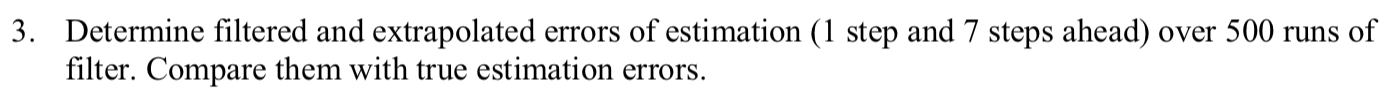

In [37]:
def error_calculation(runs=500, steps=200, T=1, sigma_a=0.2, X_init=0, V_init=0, prob_of_gap=0.2,
                         X_0=[2, 0], P_0=[[10000, 0], [0, 10000]], sigma_n=20, shift=7, sigma_a_filter=0.2):
    err_filt = np.zeros(steps)
    err_filt_pred = np.zeros(steps-shift)
    
    for i in range(runs):
        # Generating true trajectory
        x = motion_tragectory(steps, T, sigma_a=sigma_a, X_init=X_init, V_init=V_init)
        
        # Generating measurements
        z = measured_trajectory_with_gaps(x, sigma_n, prob_of_gap=prob_of_gap)
        
        # Perform Kalman filter
        X_filt, X_pred, K, P_filt, x_i_pred = kalman_filter(z, T=T, X_0=X_0, P_0=P_0, 
                                                            sigma_a=sigma_a_filter, sigma_n=sigma_n, shift=shift)
        
        # Calculate errors starting from 3rd step
        err_filt += (x - X_filt[:,0])**2
        err_filt_pred += (x_i_pred[shift:] - x[shift:])**2
    
    # Take square root for each step
    err_filt = np.sqrt(err_filt / (runs - 1))
    err_filt_pred = np.sqrt(err_filt_pred / (runs - 1))
    
    return err_filt, err_filt_pred

In [38]:
M = 500
N = 200
steps = np.linspace(2, N-2)

err_filt, err_filt_pred = error_calculation(P_0=[[10000, 0], [0, 10000]], prob_of_gap=0.2)
filt_err_estim = np.sqrt(kalman_data[3][:,0,0])

# Plot results
plot(3, [steps, steps, steps], [err_filt[2:], err_filt_pred[2:], filt_err_estim[2:]], title='Average error evolution',
     xlable='step', ylable='value',
     legend=['true estim err', 'true estim err 7 steps prediction', 'filter err cov matrix'])

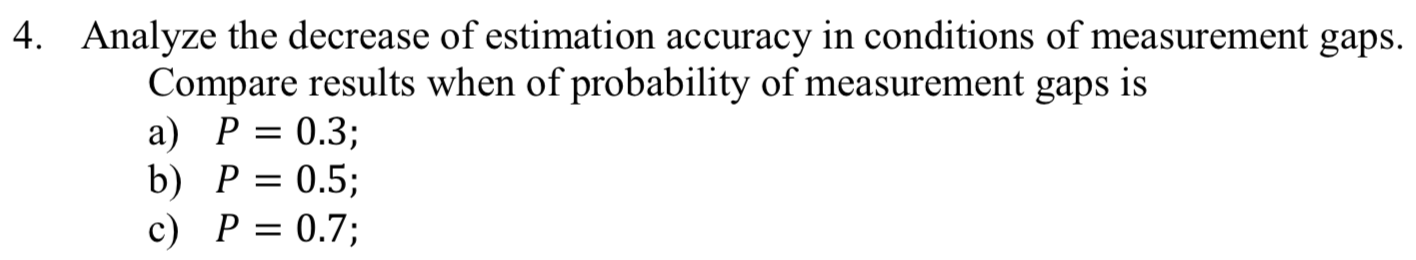

a) P = 0.3

In [39]:
M = 500
N = 200
steps = np.linspace(2, N-2)

err_filt, err_filt_pred = error_calculation(P_0=[[10000, 0], [0, 10000]], prob_of_gap=0.3)
filt_err_estim = np.sqrt(kalman_data[3][:,0,0])

# Plot results
plot(3, [steps, steps, steps], [err_filt[2:], err_filt_pred[2:], filt_err_estim[2:]], title='Average error evolution',
     xlable='step', ylable='value',
     legend=['true estim err', 'true estim err 7 steps prediction', 'filter err cov matrix'])

b) P = 0.5

In [40]:
M = 500
N = 200
steps = np.linspace(2, N-2)

err_filt, err_filt_pred = error_calculation(P_0=[[10000, 0], [0, 10000]], prob_of_gap=0.5)
filt_err_estim = np.sqrt(kalman_data[3][:,0,0])

# Plot results
plot(3, [steps, steps, steps], [err_filt[2:], err_filt_pred[2:], filt_err_estim[2:]], title='Average error evolution',
     xlable='step', ylable='value',
     legend=['true estim err', 'true estim err 7 steps prediction', 'filter err cov matrix'])

c) P = 0.7

In [42]:
M = 500
N = 200
steps = np.linspace(2, N-2)

err_filt, err_filt_pred = error_calculation(P_0=[[10000, 0], [0, 10000]], prob_of_gap=0.7)
filt_err_estim = np.sqrt(kalman_data[3][:,0,0])

# Plot results
plot(3, [steps, steps, steps], [err_filt[2:], err_filt_pred[2:], filt_err_estim[2:]], title='Average error evolution',
     xlable='step', ylable='value',
     legend=['true estim err', 'true estim err 7 steps prediction', 'filter err cov matrix'])